In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code


In [5]:
# Imports:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
import datetime

from load_and_process_data import process_data
from load_electricity_school_data import load_electricity_education
from feature_encoding_and_data_splitting import split_data, prepare_data_simple_encoding, prepare_data_polynomial_encoding
from linear_regression_functions import learn_parameters, plot_loss_history, plot_test_and_prediction, plot_linear_regression_weights

from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

###General information:
We refer the reader of this notebook to first read the README file on Github and milestone report that can be found in the Writeup folder.
####Code description:
This is the **main code** for Linear Regression prediction for this project. Codes that I used to develop this one are  Development_FeatureEncodingLinReg_firsttry.ipynb and Development_LinearRegression.ipynb. Based on these two codes, I wrote helper functions that I am importing for this code.
####Data used:
For this project, as described in milestone report, I decided, as a first step, to make electricity consumption predictions only for  buildings whose primary use type is Educational that have very small number of missing consumption data. To extend this to different types of buildings (e.g. offices) I would do one-hot encoding for the primary_use feature. 

####Aim of this code:
Using this code I would like to understand how different types of feature encodings affect the prediction of linear regression model. Two types of encodings used are named simple encoding and polynomial encoding. At the end of this code, I will provide discussion on results based on these two different approaches.

### 1. Load data:

I use the process_data function to load all the data from datafolder. This function also handles missing feature data. The breakdown of missing information for different features is given below: 
<br>

**Building features**:
* 53.4% of the year built
* 75.5% of the floor count

**Weather features**
* 9.5% of the cloud coverage
* 0.1% of the dew temperature
* 36.0% of the precipitation depth
* 7.6% of the sea level pressure
* 4.5% of the wind speed
* 0.2% of the wind direction.

In order to have the largest amount of data on which our model can learn, I filled all the missing information for the above mentioned featues. 
* For the **weather data** features, I filled the missing data by taking the average of the closest non missing values of that feature. My reasoning was that weather data changes slowly enough that missing feature values should have values close to the neighbouring non-missing values.
* For the **building data** I filled the missing data for the feature with the mean of that feature for that building's primary use group. My reasoning was that all the buidlings with the same primary use will have similar number of floors and that they could all be built at the similar time.

After this processing I use load_electricity_education function to load only electricity consumption data on educational buildings that have small number of missing consumption data. After this function I end up working with electricity consumption data over one year period for 118 buildings.

In [6]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)
# Load all Education buildings Electricity consumption data that has good 
# electricity meter reading values:
pd_educational = load_electricity_education(pd_all)

#### Plot the imported data:
Here I am plotting energy consumption data averaged over 118 buildings over 1 year period timescale.

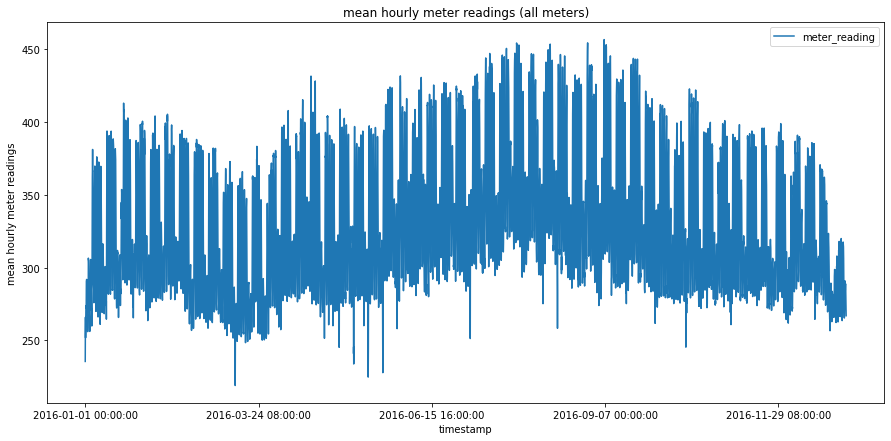

In [7]:
pd_educational.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")
plt.show()

#### Display pd_educational dataframe:

In [8]:
pd_educational

,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
1707550,72102,1970.0,5.0,2016-01-01 00:00:00,15.6,6.0,-5.6,0.0,1015.30,270.0,3.6,77.610
1707553,72102,1970.0,5.0,2016-01-01 01:00:00,13.9,4.0,-5.6,0.0,1015.60,270.0,4.1,75.830
1707556,72102,1970.0,5.0,2016-01-01 02:00:00,13.3,2.0,-5.6,0.0,1016.00,270.0,3.1,80.570
1707559,72102,1970.0,5.0,2016-01-01 03:00:00,12.2,0.0,-6.1,0.0,1016.60,280.0,3.1,81.530
1707562,72102,1970.0,5.0,2016-01-01 04:00:00,11.7,2.0,-6.7,0.0,1017.00,270.0,3.1,83.550
...,...,...,...,...,...,...,...,...,...,...,...,...
20068262,30143,1951.0,5.0,2016-12-31 19:00:00,3.0,1.0,-8.0,-1.0,1007.55,180.0,5.7,245.675
20068263,30143,1951.0,5.0,2016-12-31 20:00:00,2.8,2.0,-8.9,-1.0,1007.40,180.0,7.7,250.125
20068264,30143,1951.0,5.0,2016-12-31 21:00:00,2.8,2.0,-7.2,-1.0,1007.50,180.0,5.1,247.875
20068265,30143,1951.0,5.0,2016-12-31 22:00:00,2.2,2.0,-6.7,-1.0,1008.00,170.0,4.6,247.575


### 2. Linear regression on simply encoded data:

In an attempt to fit the data plotted above I first tried to do simple feature encoding and feed those features to our linear regression model for learning.

For this simple encoding I replaced the timestamp feature with hour, weekday and month feature. After this I normalized all the input features, including these and this was the input for my learning algorithm. I also normalized the target features in this input to have a better idea what the loss value means.


#### 2.1. Prepare data for linear regression fitting by doing feature encoding and splitting it into train and test:

Function prepare_data_simple_encoding does all the feature encoding as described above. This function also splits the data into train and test data. I wanted to have a better visual picture of what the linear regression model does for different encodings, so instead of doing random split of the data for training and testing, I decided to do more structured splitting. In this function I dedicate data from the month of June to test data, and the rest of the data I dedicate to training (+validation). I originally split the data into first 11 months for training and last month for testing, however, due to holidays, December is not typical consumption month and I ended up choosing June instead for test. For the next step in this project, I can find a better way to split the data into train and test.

In [9]:
train_data_s, test_data_s, timestamp_train_s, timestamp_test_s = prepare_data_simple_encoding(pd_educational) 

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code/feature_encoding_and_data_splitting.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]


#### 2.2. Do linear regression fit:

Function learn_parameters will take the train and test data, learning rate and batch size and it will perform linear regression model fit to the train data. This function will also take 20% of the training data and it will use it for validation. I use Mean Squared error as a loss function, and Adam optimization as an optimizer. The learning rate and batch size provided below gave me the best fitting to the test data.

In [10]:
linear_regression_model_s, history_s = learn_parameters(train_data_s, test_data_s, 0.00003, 256 )

Epoch 1/15
2823/2823 [==============================] - 8s 2ms/step - loss: 1.3805 - val_loss: 1.5562
Epoch 2/15
2823/2823 [==============================] - 6s 2ms/step - loss: 1.0696 - val_loss: 1.2467
Epoch 3/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.8720 - val_loss: 1.0327
Epoch 4/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.7404 - val_loss: 0.8907
Epoch 5/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.6570 - val_loss: 0.8029
Epoch 6/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.6153 - val_loss: 0.7506
Epoch 7/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.5952 - val_loss: 0.7224
Epoch 8/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.5949 - val_loss: 0.7077
Epoch 9/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.5943 - val_loss: 0.7025
Epoch 10/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.592

#### 2.3. Plot learning history of linear regression:

Here I am plotting learning history of linear regression model for the case of simple encoding.

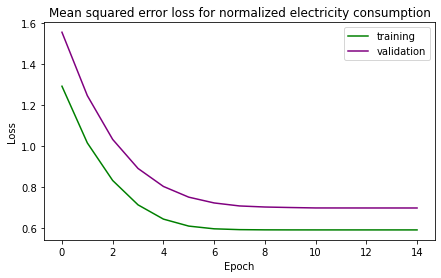

In [11]:
plot_loss_history(history_s)

#### 2.4. Plot test data and our prediction with this model for visual comparioson:

In this part I am plotting test data in orange and our prediction in gray for the linear regression model with simple feature encoding. 

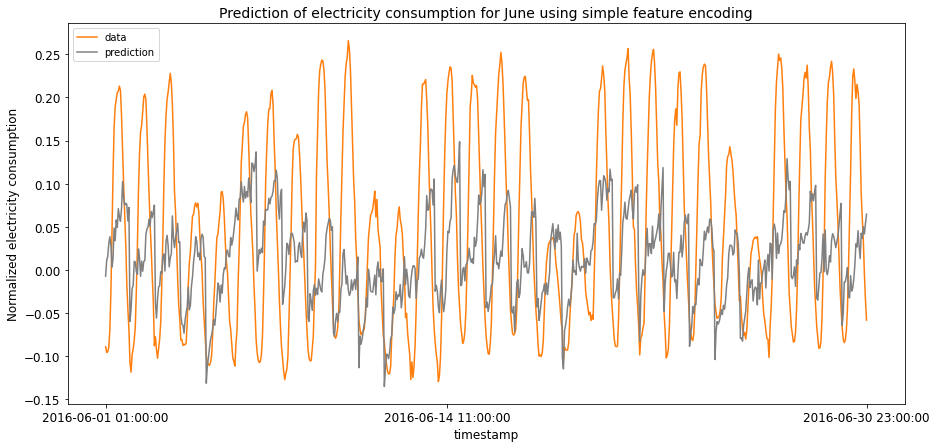

In [12]:
plot_test_and_prediction(test_data_s, timestamp_test_s, linear_regression_model_s, 'simple')

#### 2.5. Plot weights that our model gave to different encoded features:

I was also interested to know which features contribute the most to the model, and the plot below shows this. As expected square_feet has huge contribution, however, a bit undexpected to me, the rest of the features (expect from floor_count and percipitation depth) seem to have very similar weight after learning. I was expecting time features and air_temperature to have more significant contribution than they actually have. 

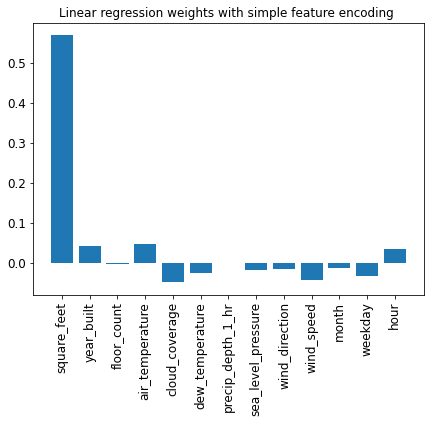

In [13]:
plot_linear_regression_weights(train_data_s,linear_regression_model_s, 'simple')

### 3. Linear regression on polynomially encoded data:

I did polynomial encoding on timestamp and wind features data. I also made year built feature cathegorical.

**Timestamp feature** <br>
A more involved encoding, that I called polynomial encoding, was inspired by Moon et al paper that I cite in the milestone report. In this paper they transformed calendar time into a 2d continuous format. This encoding looks something like this: 

\begin{equation}
 \text{day_sin} = \sin(\frac{2\pi * \text{timestamp} }{24h})  
\end{equation}
\begin{equation}
 \text{day_cos} = \cos(\frac{2\pi * \text{timestamp} }{24h}) 
\end{equation}

Given that energy consumption has clear daily variations, if we encode day as a numeric feature, then even though 0000hrs follows right after 2359hrs, they will numerically look like they are far apart. This encoding solves this problem by substituting day feature with day_sin  and day_cos feature, with frequency that corresponds to a 24h. I used this type of encoding for day, week and year feature and with frequency of 24h, 7days and 365days respectively. <br>
I also added additional feature called is\_weekday to handle lower amplitudes of energy consumption over weekend relative to weekdays.

**Wind fearture** <br>
Wind_direction feature in units of degrees has similar issue as described above, where 0 and 359 degrees are numerically far away but in reality they are close. Thus I substituted wind_speed and wind_direction features by combining them together into wind\_x and wind\_y features. <br>

**Year built feature** <br>
For year\_built feature instead of making it numeric, I grouped it into categories of 40 year period given that histogram of year_built feature showed 3 peaks across 40 year period. <br>

After these encodings, I normalized all the input features before sending it to the learning algorithm. This encoding didn't really change our prediction much in the end.

#### 3.1. Prepare data for linear regression fitting by doing feature encoding and splitting it into train and test:

Function prepare_data_polynomial_encoding applies the polynomial encoding described above, and it does the same type of training/test splitting as described above for the prepare_data_simple_encoding function.

In [14]:
train_data_p, test_data_p, timestamp_train_p, timestamp_test_p = prepare_data_polynomial_encoding(pd_educational) 

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code/feature_encoding_and_data_splitting.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd_test = pd_test[pd.to_datetime(pd_educational["timestamp"]) < datetime.datetime(2016, 7, 1)]


#### 3.2. Do linear regression fit:

Function learn_parameters will take the train and test data, learning rate and batch size and it will perform linear regression model fit to the train data. This function will also take 20% of the training data and it will use it for validation. I use Mean Squared error as a loss function, and Adam optimization as an optimizer. The learning rate and batch size provided below gave me the best fitting to the test data.

In [15]:
linear_regression_model_p, history_p = learn_parameters(train_data_p, test_data_p, 0.00003, 256 )

Epoch 1/15
2823/2823 [==============================] - 7s 2ms/step - loss: 3.6880 - val_loss: 2.9522
Epoch 2/15
2823/2823 [==============================] - 6s 2ms/step - loss: 2.6843 - val_loss: 2.2718
Epoch 3/15
2823/2823 [==============================] - 6s 2ms/step - loss: 1.9794 - val_loss: 1.7681
Epoch 4/15
2823/2823 [==============================] - 6s 2ms/step - loss: 1.4831 - val_loss: 1.4139
Epoch 5/15
2823/2823 [==============================] - 6s 2ms/step - loss: 1.1251 - val_loss: 1.1796
Epoch 6/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.8997 - val_loss: 1.0281
Epoch 7/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.7639 - val_loss: 0.9217
Epoch 8/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.6927 - val_loss: 0.8410
Epoch 9/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.6448 - val_loss: 0.7838
Epoch 10/15
2823/2823 [==============================] - 6s 2ms/step - loss: 0.613

#### 3.3. Plot learning history of linear regression:

Here I am plotting learning history of linear regression model for the case of polynomial encoding.

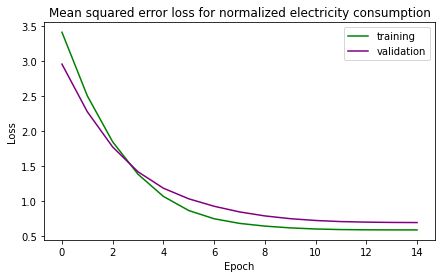

In [16]:
plot_loss_history(history_p)

#### 3.4. Plot test data and our prediction with this model for visual comparioson:

In this part I am plotting test data in orange and our prediction in gray for the linear regression model with polynomial feature encoding. <br>

As expected, the more involved encoding that takes into account cyclical nature of electricity consumption gave better prediction of the test data compared to encoding that assumed the target data depends only linearly on the input features. The polynomial encoding was able to capture hourly variations, as well as the fact that over weekend, electricity consumption was lower compared to weekday consumption for educational buildings. 

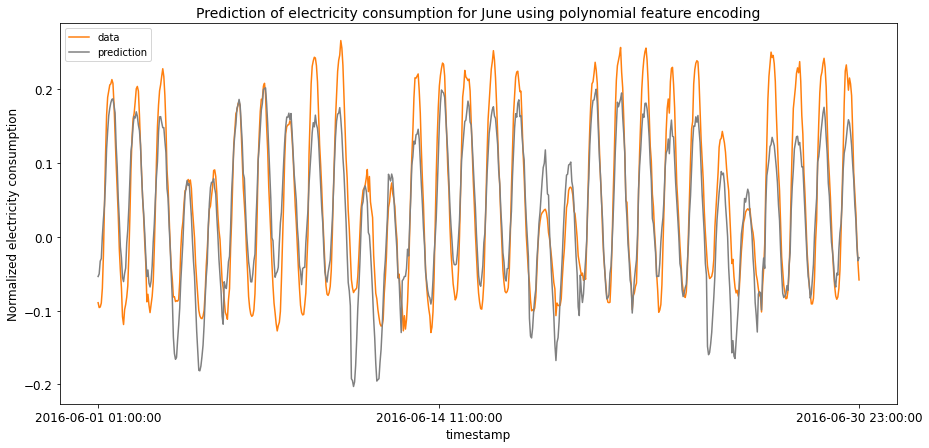

In [17]:
plot_test_and_prediction(test_data_p, timestamp_test_p, linear_regression_model_p, 'polynomial')

#### 3.5. Plot weights that our model gave to different encoded features:

Just like in previous section I am here plotting weights of linear regression model. Square_feet has huge contribution again, but the rest of the features don't seem to be as dominant as the square_feet which was surprising to me. 

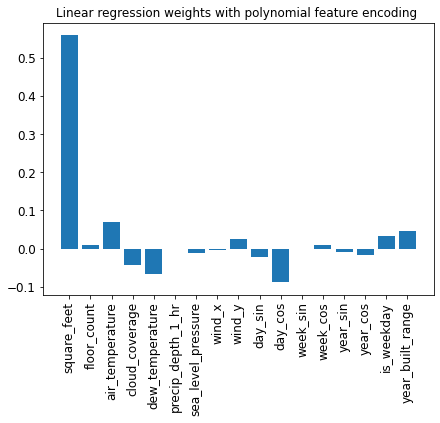

In [18]:
plot_linear_regression_weights(train_data_p,linear_regression_model_p, 'polynomial')